<a href="https://colab.research.google.com/github/Chikuji/AzureML/blob/master/2020_09_23_03_AjusteHimerparametrosAML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objetivos de aprendizado

Neste módulo, você aprenderá como:

- Defina um espaço de pesquisa de hiperparâmetro.
-Configure a amostragem de hiperparâmetros.
-Selecione uma política de rescisão antecipada.
-Execute um experimento de ajuste de hiperparâmetros.

![08-01-hyperdrive[1].png](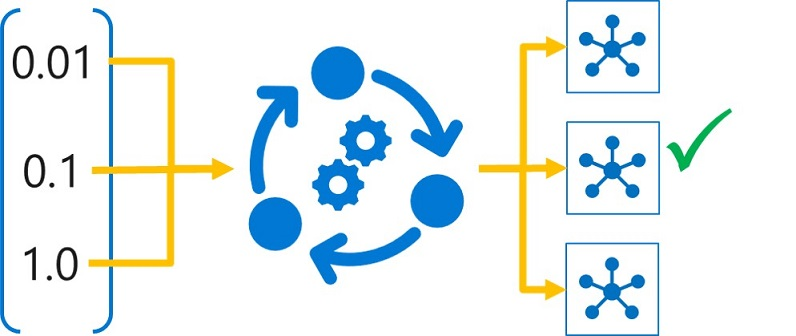)

# Definindo um espaço de busca

Hiperparâmetros discretos

Você pode definir um espaço de pesquisa para um parâmetro discreto usando uma escolha de uma lista de valores explícitos, que você pode definir como uma lista Python ( choice([10,20,30])), um intervalo ( choice(range(1,10))) ou um conjunto arbitrário de valores separados por vírgulas ( choice(30,50,100))

Você também pode selecionar valores discretos de qualquer uma das seguintes distribuições discretas:

- qnormal
-quniforme
-qlognormal
-qloguniforme

Hiperparâmetros contínuos

- normal
-uniforme
-lognormal
-loguniforme

Definindo um espaço de busca

In [ ]:
from azureml.train.hyperdrive import choice, normal

param_space = {
                 '--batch_size': choice(16, 32, 64),
                 '--learning_rate': normal(10, 3)
              }

# Configurando a amostragem

Amostragem de grade

amostragem de grade é usada para tentar todas as combinações possíveis de batch_size discreto e valor learning_rate :

In [ ]:
from azureml.train.hyperdrive import GridParameterSampling, choice

param_space = {
                 '--batch_size': choice(16, 32, 64),
                 '--learning_rate': choice(0.01, 0.1, 1.0)
              }

param_sampling = GridParameterSampling(param_space)

Amostragem aleatória

In [ ]:
from azureml.train.hyperdrive import RandomParameterSampling, choice, normal

param_space = {
                 '--batch_size': choice(16, 32, 64),
                 '--learning_rate': normal(10, 3)
              }

param_sampling = RandomParameterSampling(param_space)

Amostragem bayesiana

In [ ]:
from azureml.train.hyperdrive import BayesianParameterSampling, choice, uniform

param_space = {
                 '--batch_size': choice(16, 32, 64),
                 '--learning_rate': uniform(0.5, 0.1)
              }

param_sampling = BayesianParameterSampling(param_space)

# Configurando rescisão antecipada

Para ajudar a evitar perda de tempo, você pode definir uma política de encerramento antecipado que abandona as execuções que provavelmente não produzirão um resultado melhor do que as execuções concluídas anteriormente.

Política de bandidos

Você pode usar uma política de bandido para interromper uma execução se a métrica de desempenho de destino for inferior à melhor execução até agora por uma margem especificada.

Você também pode aplicar uma política de bandidos usando um fator de folga , que compara a métrica de desempenho como uma proporção em vez de um valor absoluto.

In [ ]:
from azureml.train.hyperdrive import BanditPolicy

early_termination_policy = BanditPolicy(slack_amount = 0.2,
                                        evaluation_interval=1,
                                        delay_evaluation=5)

Política de parada média

In [ ]:
from azureml.train.hyperdrive import MedianStoppingPolicy

early_termination_policy = MedianStoppingPolicy(evaluation_interval=1,
                                                delay_evaluation=5)

Política de seleção de truncamento

In [ ]:
from azureml.train.hyperdrive import TruncationSelectionPolicy

early_termination_policy = TruncationSelectionPolicy(truncation_percentage=10,
                                                     evaluation_interval=1,
                                                     delay_evaluation=5)

# Criação de um script de treinamento para ajuste de hiperparâmetros

Para executar um experimento de hiperdrive, você precisa criar um script de treinamento da mesma forma que faria para qualquer outro experimento de treinamento, exceto que seu script deve :

- Inclua um argumento para cada hiperparâmetro que deseja variar.
-Registre a métrica de desempenho de destino. Isso permite que a execução do hyperdrive avalie o desempenho das execuções filho que ele inicia e identifique aquele que produz o modelo de melhor desempenho.

In [ ]:
import argparse
import joblib
from azureml.core import Run
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Get regularization hyperparameter
parser = argparse.ArgumentParser()
parser.add_argument('--regularization', type=float, dest='reg_rate', default=0.01)
args = parser.parse_args()
reg = args.reg_rate

# Get the experiment run context
run = Run.get_context()

# load the training dataset
data = run.input_datasets['training_data'].to_pandas_dataframe()

# Separate features and labels, and split for training/validatiom
X = data[['feature1','feature2','feature3','feature4']].values
y = data['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

# Train a logistic regression model with the reg hyperparameter
model = LogisticRegression(C=1/reg, solver="liblinear").fit(X_train, y_train)

# calculate and log accuracy
y_hat = model.predict(X_test)
acc = np.average(y_hat == y_test)
run.log('Accuracy', np.float(acc))

# Save the trained model
os.makedirs('outputs', exist_ok=True)
joblib.dump(value=model, filename='outputs/model.pkl')

run.complete()

Configurar e executar um experimento de hiperdrive

In [ ]:
from azureml.core import Experiment
from azureml.train.hyperdrive import HyperDriveConfig, PrimaryMetricGoal

# Assumes ws, sklearn_estimator and param_sampling are already defined

hyperdrive = HyperDriveConfig(estimator=sklearn_estimator,
                              hyperparameter_sampling=param_sampling,
                              policy=None,
                              primary_metric_name='Accuracy',
                              primary_metric_goal=PrimaryMetricGoal.MAXIMIZE,
                              max_total_runs=6,
                              max_concurrent_runs=4)

experiment = Experiment(workspace = ws, name = 'hyperdrive_training')
hyperdrive_run = experiment.submit(config=hyperdrive)

Monitorar e revisar execuções do hyperdrive

O experimento iniciará uma execução secundária para cada combinação de hiperparâmetro a ser tentada, e você pode recuperar as métricas registradas dessas execuções usando o seguinte código:

In [ ]:
for child_run in run.get_children():
    print(child_run.id, child_run.get_metrics())

Você também pode listar todas as execuções em ordem decrescente de desempenho, como esta:

In [ ]:
for child_run in hyperdrive_.get_children_sorted_by_primary_metric():
    print(child_run)

Para recuperar a execução de melhor desempenho, você pode usar o seguinte código:

In [ ]:
best_run = hyperdrive_run.get_best_run_by_primary_metric()